In [1]:
!uv add -qU langgraph langchain langchain-openai

In [3]:
!uv add -q python-dotenv

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

## Evaluator-Optimizer

### Model

In [6]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-5-nano", temperature=0.7)

### State 정의

In [7]:
from typing import TypedDict

class AdState(TypedDict):
    product_name: str   #상품명
    ad_copy: str        #생성된 광고 문구
    feedback: str
    status: str
    iteration_count: int

In [8]:
from pydantic import BaseModel, Field
from typing import Literal

class EvaluationResult(BaseModel):
    status: Literal['pass', 'fail'] = Field(description='기준 충족 여부')
    feedback: str = Field(description='탈락 시 구체적인 수정 사항')

In [9]:
evaluator_llm = model.with_structured_output(EvaluationResult)

### Node 정의

In [22]:
# [Generator] 신입 카피라이터
def copywriter_node(state: AdState):
    product = state['product_name']
    feedback = state.get('feedback')
    count = state.get('iteration_count', 0)

    print(f"\n--- [Copywriter] 광고 문구 작성 중 (시도: {count + 1} )---")

    if not feedback:
        " 첫 시도는 좀 건조하게 작성하도록 유도 (Fail을 유발하기 위해)"
        prompt = f"'{product}'의 기능 위주로 인스타그램 홍보 문구를 건조하게 작성해줘. 홍보 문구만 답변하고 반드시 20자 이내로 작성해줘"
    else:
        # 피드백 반영
        prompt = f"""
        '{product}' 인스타그램 홍보 문구를 다시 작성해.

        <반드시 지켜야 할 수정 사항>
        {feedback}
        </반드시 지켜야 할 수정 사항>

        <작성 시 반드시 지켜야할 사항>
        홍보 문구만 답변하고 절대 50자 이하로 작성하시오.
        </작성 시 반드시 지켜야할 사항>
        """
    res = model.invoke(prompt)
    return {'ad_copy': res.content, 'iteration_count' : count + 1}

In [23]:
# [Evaluator] 감성적인 마케팅 팀장
def manager_node(state: AdState):
    ad_copy = state['ad_copy']

    print(f"\n--- [Manager] 문구 검수 중 ---")

    print(f"   ㄴ 신입이 쓴 글: {ad_copy}")

    prompt = f"""
    당신은 깐깐한 마케팅 팀장입니다. 신입 사원이 쓴 다음 광고 문구를 평가하세요:

    "{ad_copy}"

    <평가 기준>
    1. (정량) 해시태크(#)가 3개 이상 있어야 합니다.
    2. (정량) '할인' 또는 '특가'라는 단어가 포함되어야 합니다.
    3. (정성 - 중요!) **문구가 너무 설명문 같거나 딱딱하면 안 됩니다. 소비자의 감성을 자극하는 '활기차고 매력적인 톤' 이어야합니다
    </평가 기준>

    위 3가지 기준 중. ㅏ나라도 부족하면 fail을 주세요.
    특히 3번(톤앤매너) 이 부족하다면 "좀 더 감성적으로 쓰세요" 같이 100자 이내로 조언하세요.
    """

    res = evaluator_llm.invoke(prompt)

    print(f"  ㄴ 판정: {res.status.upper()}")


    return {'status': res.status, 'feedback': res.feedback}

### 그래프 생성

In [24]:
from langgraph.graph import StateGraph, START, END

In [25]:
# 4. 루프 로직
def route_submission(state: AdState):
    status = state['status']
    iteration_count = state['iteration_count']

    if status == 'pass':
        print()
        return END
    if iteration_count >=3:
        return END
    
    return 'copywriter_node'

In [26]:
# 5. 그래프 생성
workflow = StateGraph(AdState)
workflow.add_node("copywriter_node", copywriter_node)
workflow.add_node("manager_node", manager_node)

workflow.add_edge(START, 'copywriter_node')
workflow.add_edge('copywriter_node', 'manager_node')

workflow.add_conditional_edges(
    'manager_node',
    route_submission,
    ['copywriter_node', END]
)

In [27]:
app = workflow.compile()

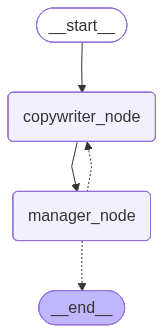

In [28]:
app

In [29]:
inputs = {"product_name": "자율주행 자동차"}
result = app.invoke(inputs)


--- [Copywriter] 광고 문구 작성 중 (시도: 1 )---

--- [Manager] 문구 검수 중 ---
   ㄴ 신입이 쓴 글: 자율주행으로 안전한 주행
실시간 지도 업데이트
센서와 AI로 안전한 주행
경로 최적화로 연비 절약
자율주행 보조로 피로 감소
충돌 방지 센서로 안전


/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationResult(status='...을 바꿔보세요."), input_type=EvaluationResult])
  return self.__pydantic_serializer__.to_python(


  ㄴ 판정: FAIL

--- [Copywriter] 광고 문구 작성 중 (시도: 2 )---

--- [Manager] 문구 검수 중 ---
   ㄴ 신입이 쓴 글: 자율주행차로 더 안전하고 편리해요! 할인 특가 놓치지 마세요 #자율주행차 #특가 #할인
  ㄴ 판정: PASS



/Users/sup_kimba/langgraph-basic/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationResult(status='...에 부합합니다."), input_type=EvaluationResult])
  return self.__pydantic_serializer__.to_python(


In [30]:
result

{'product_name': '자율주행 자동차',
 'ad_copy': '자율주행차로 더 안전하고 편리해요! 할인 특가 놓치지 마세요 #자율주행차 #특가 #할인',
 'feedback': "해시태그 3개 이상이며, '할인' 또는 '특가' 포함. 톤도 활기차고 매력적이어서 마케팅 목표에 부합합니다.",
 'status': 'pass',
 'iteration_count': 2}